<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
Non-Linear Least Squares Optimization
</h1>

Accompanying notebook for the recipe:

  * Christian Bauckhage: "NumPy / SciPy Recipes for Data Science:
Non-Linear Least Squares Optimization",<br/>Technical Report, March 2015 ([Download from ResearchGate](https://www.researchgate.net/publication/273872578_NumPy_SciPy_Recipes_for_Data_Science_Non-Linear_Least_Squares_Optimization))

  * Abstract of the paper: *In this brief note, we continue our study of least squares optimization for model fitting. By means of examples, we show how least squares approaches allow us to fit polynomials to uni- and multivariate observations.*
    
<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
import numpy.polynomial as pol

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Comparison of  `vander` and `polyvander`

Let us use an example to compare the behavior of the function `numpy.vander` and the function `numpy.polynomial.polynomial.polyvander`. `numpy.vander` understands the second parameter (here: 3) as the number of columns.

In [3]:
a = np.array([1, 2, 3, 4])
np.vander(a, 3)

array([[ 1,  1,  1],
       [ 4,  2,  1],
       [ 9,  3,  1],
       [16,  4,  1]])

`polyvander` understands the the second parameter (here: 3) as the degree of
the corresponding polynomial $y(x) = w_3 x^3 + w_2 x^2 + w_1 x^1 + w_0 x^0$. 


In [4]:
pol.polynomial.polyvander(a, 3)

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

### Remarks on  `polyvander2d` 

Notice that the order of the columns in `polyvander` is reversed compared to `vander`. This has the benefit, that the index $k$ in $w_k$ can be interpreted as the exponent of its corresponding monomial $x^k$ as well index of $w_k$ in the vector of coefficients $(w_0, w_1, w_2, w_3)^T$.

If we are now exploring polynoms of two variables, this tells us which order to expect in `polyvander2d`. Let us consider the polynomial $z(x, y) = v_{1, 1} x y + v_{1, 0} x  + v_{0, 1} y + v_{0, 0}$. If we interpret the indices of the coefficients $v_{k,l}$ as their places in a matrix 
$\begin{pmatrix}
v_{0, 0} & v_{0, 1} \\
v_{1, 0} & v_{1, 1}
\end{pmatrix}$ and read the matrix line by line, we get the order $v_{0, 0},v_{0, 1}, v_{1, 0}, v_{1, 1}$.

This explains the otherwise a bit surprising order $1, y, x, xy$ = $x^0 y^0, x^0 y^1, x^1 y^0, x^1 y^1$ of the monomials in the `polyvander2d`. See equation (16) in the paper or the example below:

In [5]:
x = np.array([2, 3])
y = np.array([5, 7])

pol.polynomial.polyvander2d(x, y, [1, 1])

array([[ 1.,  5.,  2., 10.],
       [ 1.,  7.,  3., 21.]])

## Fitting a Uni-Variate Polynomial to 2D Data

In [6]:
def create_data_2D(n, w, xmin, xmax):
    x = rnd.random(n) * (xmax-xmin) + xmin
    X = np.vander(x, len(w))
    y = X.dot(w) + rnd.randn(n) + 0.5
    return x,y

We generate data points from the polynomial $y = 0.2 x^3 + 0.4 x^2 - 2.1 x - 1.5$.

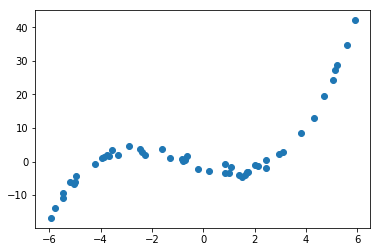

In [7]:
w = np.array([0.2, 0.4, -2.1, -1.5])
x, y = create_data_2D(50, w, -6, 6)

plt.scatter(x, y)
plt.show()

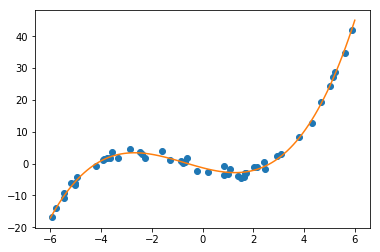

In [8]:
w = la.lstsq(np.vander(x, 4), y)[0]
xs = np.linspace(-6, 6, 100)
ys = np.dot(np.vander(xs, 4), w)

plt.plot(x, y, 'o');
plt.plot(xs, ys, '-')
plt.show()

## Fitting a Bi-Variate Polynomial to 3D Data

In [9]:
def create_data_3D(n, v, p, q, xmin, xmax, ymin, ymax):
    x = rnd.random(n) * (xmax-xmin) + xmin
    y = rnd.random(n) * (ymax-ymin) + ymin
    
    Y = pol.polynomial.polyvander2d(x, y, [p, q])
    z = Y.dot(v) + rnd.randn(n) * 0.5
    
    return x, y, z

We generate data points from the polynomial $z = -2 x y + 0.5 x + 0.5 y + 1$. The coefficients $v_{1, 1} = -2$, $v_{1, 0} = 0.5$, $v_{0, 1} = 0.5$, and $v_{0, 0} = 1$ are passed to `create_data_3D` in the order of `polyvander2d`: $(v_{0, 0}, v_{0, 1}, v_{1, 0}, v_{1, 1})$.

In [10]:
v = np.array([1., 0.5, 0.5, -2.])

x, y, z = create_data_3D(100, v, 1, 1, -2, 2, -2, 2)

Y = pol.polynomial.polyvander2d(x, y, [1, 1])
v = la.lstsq(Y, z)[0]

In [11]:
def plot_bilinear_model(x, y, z, v, xmin, xmax, ymin, ymax):
    xs = np.linspace(xmin, xmax, 21)
    ys = np.linspace(ymin, ymax, 21)
    
    V = v.reshape(2,2)
    Z = pol.polynomial.polygrid2d(xs, ys, V)
    
    X, Y = np.meshgrid(xs, ys)
    
    fig = plt.figure()
    axs = Axes3D(fig, azim=50, elev=40)
    
    axs.plot_wireframe(X, Y, Z, color='orange')
    axs.scatter(x, y, z)
      
    plt.show()
    
# Changes compared to the paper: 
# Set the viewpoint to azim=50, elev=40 and
# forced the color of the wireframe to orange

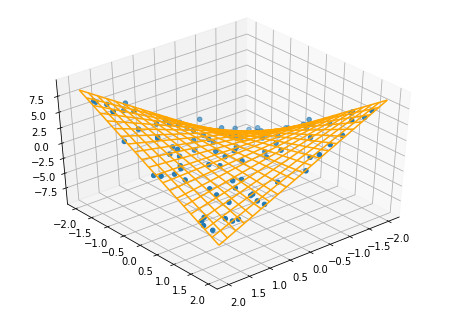

In [12]:
plot_bilinear_model(x, y, z, v, x.min(), x.max(), y.min(), y.max())

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; C. Bauckhage and O. Cremers<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>